In this notebook, I recreate the pseudocode given for the unrolled ISTA algorithm in *Unrolled Algorithms*. This is the third notebook in the series, and in it, I compare the results of unrolled ISTA to ISTA and FISTA. 

# Introduction 


## What is algorithm unrolling?

The general concept behind algorithm unrolling is that you take an algrithm that runs for a fixed number of iterations, and you turn every iteration into a layer in a neural network. Many times this takes the form of a residual neural network. Residual neural networks are neural networks composed of blocks of smaller networks. They usually take the output of a given block of layers and combine it with some previous output. This form aligns well with iteration-based algorithms, because you can take the output from one iteration and append it to an overall output. 

The reason why this meta-algorithm was created was to merge traditional signal processing approaches with deep learning.  Traditional approaches, which are classic, domain knowledge inspired algorithms like ISTA,  are interpretable but not high performing and neural networks are high performing and not interpretable. The result is something that is both interpretable and high performing.

Another big advantage to this is that it learns the parameters for you, so if you have an algorithm like ISTA, where the end result is very dependent on initial conditions and parameters, you don't have to worry about choosing the right ones.

## Unrolled ISTA

The first mental baseline we have to create when reinterpreting ISTA as an unrolled algorithm is rewriting the ISTA formula. In the first notebook in this series, we saw ISTA written as $\hat{x}_{n} = S_{\lambda, \alpha}(\hat{x}_{n-1} + \alpha A^{T}(y - A \hat{x}_{n-1})$. However, the unrolled ISTA algorithm uses the form $\hat{x}_{n} = S_{\lambda} ((I - \frac{1}{\alpha} W^{T} W)x_{n-1} + \frac{1}{\alpha} W^{T} y)$

This equation is just a rewriting of the ISTA form that we know: 

$$ S_{\lambda} ((I - \frac{1}{\alpha} W^{T} W)x_{n-1} + \frac{1}{\alpha} W^{T} y) \\
= S_{\lambda} (x_{n-1} - \frac{1}{\alpha} W^{T} W x_{n-1} + \frac{1}{\alpha} W^{T} y) \\
= S_{\lambda} (x_{n-1} - \frac{1}{\alpha} W^{T}( W x_{n-1} + y))$$

If we replace $W$ with $A$, we get the equation from previous notebooks. 

Notice that in the form $S_{\lambda} ((I - \frac{1}{\alpha} W^{T} W)x_{n-1} + \frac{1}{\alpha} W^{T} y)$, we can combine all our parameters to use the form $S_{\lambda} (W_{t}x_{n-1} + W_{e} y)$. Since deep learning models do not need the parameters one by one, we can combine all the parameters into these two terms and ask our model to learn them instead. 

ISTA is composed of calculating $S_{\lambda} (W_{t}x_{n-1} + W_{e} y)$ a predetermined number of times. Therefore, we can draw one block of the ISTA unrolled network as: 

![oneblock](https://github.com/AlliBusa/denoising-self-study/blob/main/ISTA_onelayer.png)

This neural network block quite closely follows the equation above. $x_{n}$ gets transformed by $W_{t}$ and $y$ by $W_{e}$ the result gets added together and put through a soft htresholding function. Then, we can take the result and put it as the next $x_{n}$ input in the next layer of the network. The full model thus looks like: 

![multipleblocks](https://github.com/AlliBusa/denoising-self-study/blob/main/ISTA_full.png)

# Implementation

## Importing and preprocessing data

In [1]:
import os
import numpy as np
import torch
from torch import nn
# from utils import NNRegressor
# import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from skimage.metrics import peak_signal_noise_ratio

We will be using the BSDS500 library. 

In [2]:


# Assuming you have the training and testing sets stored as numpy arrays
train_noisy_images = np.load('./BSDS500/train_noisy_array.npy')
train_clean_images = np.load('./BSDS500/train_original_array.npy')
test_noisy_images = np.load('./BSDS500/test_noisy_array.npy')
test_clean_images = np.load('./BSDS500/test_original_array.npy')

# Convert numpy arrays to PyTorch tensors
train_noisy_images = torch.from_numpy(train_noisy_images).float().permute(0,3,2,1)
train_clean_images = torch.from_numpy(train_clean_images).float().permute(0,3,2,1)
test_noisy_images = torch.from_numpy(test_noisy_images).float().permute(0,3,2,1)
test_clean_images = torch.from_numpy(test_clean_images).float().permute(0,3,2,1)

# Define hyperparameters
K = 10  # Number of layers
F = 3  # Number of filters
step = 0.1  # Step size
batch_size = 32
num_epochs = 100
learning_rate = 0.001

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(train_noisy_images, train_clean_images)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_dataset = TensorDataset(test_noisy_images, test_clean_images)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [3]:
X_train = np.load('./BSDS500/train_noisy_array.npy')
print(f"Shape of training data: {X_train.shape}")
print(f"Data type: {type(X_train)}")

Shape of training data: (302, 180, 180, 3)
Data type: <class 'numpy.ndarray'>


In [4]:
class unfolded_ISTA(nn.Module):

    def __init__(self, K, F,step):
        super(unfolded_ISTA, self).__init__()
        self.K = K
        self.F = F
        self.step = step
        self.norm_net=0
        # convolution layers
        self.conv = nn.ModuleList()
        for i in range(self.K):
            # self.conv.append(nn.Conv2d(1,F,1,padding=1,bias=False))
            # self.conv.append(nn.Conv2d(F, 1, 1, padding=1,bias=False))
            self.conv.append(nn.Conv2d(3,F,3,padding=1,bias=False))
            self.conv.append(nn.Conv2d(F, 3, 3, padding=1,bias=False))
            
        # learnable threshold parameter
        self.lambda_ = nn.Parameter(torch.Tensor([1.0]))

        # self.conv.append(nn.Conv2d(C, 3, 3, padding=1,bias=False))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(
                self.conv[i].weight.data, nonlinearity='relu')

    def forward(self, x):
        K = self.K
        # Initialization
        
        x_pred = self.conv[0](x)
        #1st---> [K-1]-th layer
        for i in range(K):
            x_pred = self.conv[i](x_pred)
            y_w = self.conv[i+1](x)
            x_pred = torch.nn.functional.softshrink(y_w+x_pred, np.float(self.lambda_ * self.step))
        
        return x_pred

In [5]:

# Initialize the unfolded_ISTA network
net = unfolded_ISTA(K, F, step)


In [6]:
net(train_noisy_images)

/tmp/ipykernel_39060/3439337148.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pred = torch.nn.functional.softshrink(y_w+x_pred, np.float(self.lambda_ * self.step))


tensor([[[[-1.6547e+03, -2.0273e+03, -2.8571e+03,  ..., -2.5333e+03,
            2.4877e+03,  5.9936e+02],
          [ 4.7285e+02,  5.6585e+02, -1.2756e+03,  ..., -5.2685e+03,
            5.6241e+02, -6.0953e+02],
          [-1.9545e+02,  2.4886e+02, -3.3520e+03,  ..., -9.0115e+03,
           -7.3991e+03, -2.2646e+03],
          ...,
          [ 2.0405e+03, -3.3687e+02,  6.3305e+02,  ...,  9.5160e+02,
           -2.2324e+03,  1.2234e+02],
          [-1.7987e+02,  1.1928e+03, -2.1858e+03,  ...,  2.8328e+03,
            3.3361e+02,  6.2473e+02],
          [ 3.9788e+02,  3.3575e+03, -1.5269e+03,  ...,  4.7833e+03,
            4.0105e+03,  1.9616e+03]],

         [[-7.5919e+02, -4.4698e+02, -3.0182e+03,  ..., -7.3621e+03,
           -1.8876e+03,  4.6822e+03],
          [-4.2229e+02,  5.4132e+02, -3.4124e+03,  ..., -8.1292e+03,
           -6.0289e+03,  6.9546e+03],
          [ 8.6053e+02,  1.8934e+03, -2.8756e+03,  ..., -3.3213e+03,
           -6.6087e+03,  6.1741e+03],
          ...,
     

In [8]:


# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Training loop
net.train()
for epoch in range(200):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        # print(i)
        # print(np.shape(data[0]))
        # print(inputs.size())
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print('Epoch [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, running_loss / len(train_loader)))



/tmp/ipykernel_39060/3439337148.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pred = torch.nn.functional.softshrink(y_w+x_pred, np.float(self.lambda_ * self.step))


Epoch [1/100], Loss: 110388.5797
Epoch [2/100], Loss: 59976.4117
Epoch [3/100], Loss: 38282.5752
Epoch [4/100], Loss: 27371.1021
Epoch [5/100], Loss: 21098.9160
Epoch [6/100], Loss: 17113.6249
Epoch [7/100], Loss: 14371.3488
Epoch [8/100], Loss: 12364.4833
Epoch [9/100], Loss: 10825.8666
Epoch [10/100], Loss: 9604.1868
Epoch [11/100], Loss: 8608.6577
Epoch [12/100], Loss: 7781.2403
Epoch [13/100], Loss: 7082.8184
Epoch [14/100], Loss: 6485.7475
Epoch [15/100], Loss: 5969.9236
Epoch [16/100], Loss: 5520.3577
Epoch [17/100], Loss: 5125.6202
Epoch [18/100], Loss: 4776.6275
Epoch [19/100], Loss: 4466.2825
Epoch [20/100], Loss: 4188.9197
Epoch [21/100], Loss: 3939.8209
Epoch [22/100], Loss: 3715.1911
Epoch [23/100], Loss: 3511.8547
Epoch [24/100], Loss: 3327.0625
Epoch [25/100], Loss: 3158.5312
Epoch [26/100], Loss: 3004.3741
Epoch [27/100], Loss: 2862.9442
Epoch [28/100], Loss: 2732.7592
Epoch [29/100], Loss: 2612.6182
Epoch [30/100], Loss: 2501.4604
Epoch [31/100], Loss: 2398.3311
Epoch [

In [23]:

class SimpleConvNet(nn.Module):
    def __init__(self, K, F,step):
            super(SimpleConvNet, self).__init__()
            self.K = K
            self.F = F
            self.step = step
            self.norm_net=0
            # convolution layers
            self.conv = nn.ModuleList([nn.Conv2d(3,3,3, padding=1,bias=False) for i in range(self.K)])

            # apply He's initialization
            for i in range(len(self.conv[:-1])):
                nn.init.kaiming_normal_(
                    self.conv[i].weight.data, nonlinearity='relu')

    def forward(self, x):

        for i in range(self.K):
             x = nn.functional.relu(self.conv[i](x))

        return x
    
simplenet = SimpleConvNet(K,F,step)


In [24]:


# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(simplenet.parameters(), lr=learning_rate)

# Training loop
net.train()
for epoch in range(200):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = simplenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print('Epoch [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, running_loss / len(train_loader)))



Epoch [1/100], Loss: 15006.8995
Epoch [2/100], Loss: 13033.9833
Epoch [3/100], Loss: 7933.9253
Epoch [4/100], Loss: 5161.6735
Epoch [5/100], Loss: 3729.7518
Epoch [6/100], Loss: 2904.5938
Epoch [7/100], Loss: 2582.2422
Epoch [8/100], Loss: 2351.2703
Epoch [9/100], Loss: 2160.8161
Epoch [10/100], Loss: 2007.8498
Epoch [11/100], Loss: 1862.4038
Epoch [12/100], Loss: 1698.3508
Epoch [13/100], Loss: 1583.1630
Epoch [14/100], Loss: 1509.8683
Epoch [15/100], Loss: 1446.6403
Epoch [16/100], Loss: 1391.6206
Epoch [17/100], Loss: 1337.3977
Epoch [18/100], Loss: 1283.9992
Epoch [19/100], Loss: 1236.9846
Epoch [20/100], Loss: 1196.6765
Epoch [21/100], Loss: 1162.8857
Epoch [22/100], Loss: 1134.1219
Epoch [23/100], Loss: 1109.4631
Epoch [24/100], Loss: 1088.0799
Epoch [25/100], Loss: 1069.3432
Epoch [26/100], Loss: 1052.8459
Epoch [27/100], Loss: 1038.3435
Epoch [28/100], Loss: 1025.5246
Epoch [29/100], Loss: 1014.1612
Epoch [30/100], Loss: 1004.0666
Epoch [31/100], Loss: 995.0293
Epoch [32/100], 

## Evaluation

We will be evaluating the model the same well as we evaluated the *Unrolled Optimization with Deep Priors* model. That is to say, we will use the Peak Signal to Noise Ratio, first image by image, then for the whole dataset. 

In [25]:
# run model on test set
unrolledISTAPredictions = net(test_noisy_images)

/tmp/ipykernel_39060/3439337148.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pred = torch.nn.functional.softshrink(y_w+x_pred, np.float(self.lambda_ * self.step))


In [26]:
# run model on test set
simpleNN = simplenet(test_noisy_images)

In [27]:
def evaluateImage(ytest, Xtest, y_pred, ind):
  """
  A function to evaluate the performance of a model on one image, using PSNR.

  Args:
      ytest (_type_): The original image dataset
      Xtest (_type_): The noisy image dataset that went into the ML model
      y_pred (_type_): The images cleaned by the ML model
      ind (_type_): The index to index the three above datasets at. The purpose of this is to evaluate only one image in the dataset, instead of all of them.
  """


  # Print out PSNR values
  print(f'PSNR for ML model: \n {peak_signal_noise_ratio(ytest[ind,:,:,:].numpy(), y_pred[ind,:,:,:].detach().numpy(),data_range=255)}')
  print(f'PSNR for the original noise image with the clean one : \n {peak_signal_noise_ratio(ytest[ind,:,:,:].numpy(), Xtest[ind,:,:,:].detach().numpy(), data_range=255)}')

  # Plot the images
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  axes[0].imshow(np.transpose(y_pred[ind,:,:,:].detach().numpy(), (1,2,0)).astype(int))
  axes[0].set_title("ML cleaned Image")

  axes[1].imshow(np.transpose(Xtest[ind,:,:,:].detach().numpy(), (1,2,0)).astype(int))
  axes[1].set_title("Noisy Image")

  axes[2].imshow(np.transpose(ytest[ind,:,:,:].numpy(), (1,2,0)).astype(int))
  axes[2].set_title("Original Image")

  plt.show()



Let's pick an individual image to evaluate:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR for ML model: 
 23.375585509260443
PSNR for the original noise image with the clean one : 
 20.600089230999462


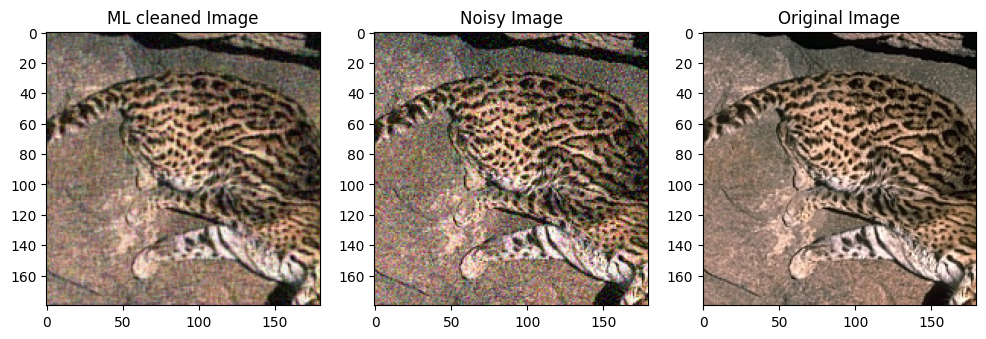

In [28]:
evaluateImage(test_clean_images, test_noisy_images, unrolledISTAPredictions, 9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR for ML model: 
 20.82107548041487
PSNR for the original noise image with the clean one : 
 20.600089230999462


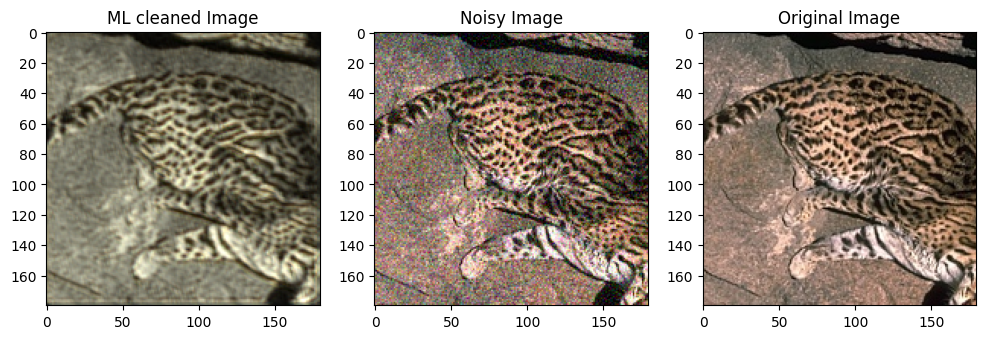

In [29]:
evaluateImage(test_clean_images, test_noisy_images, simpleNN, 9)

Now let's look at multiple images. 

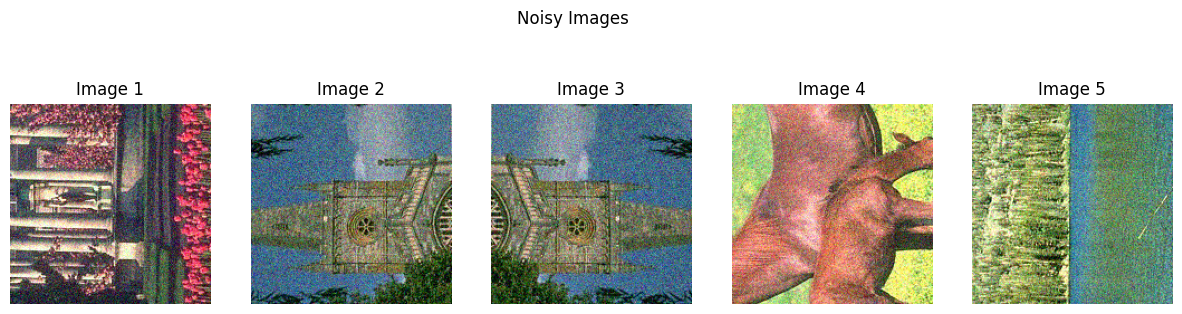

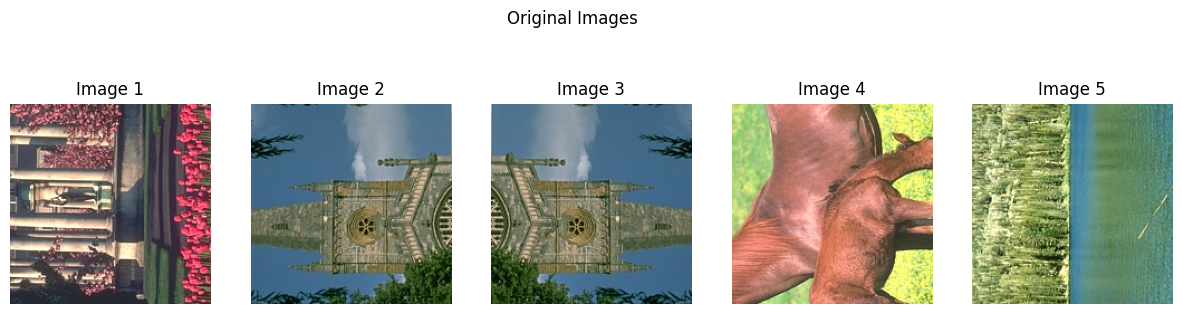

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


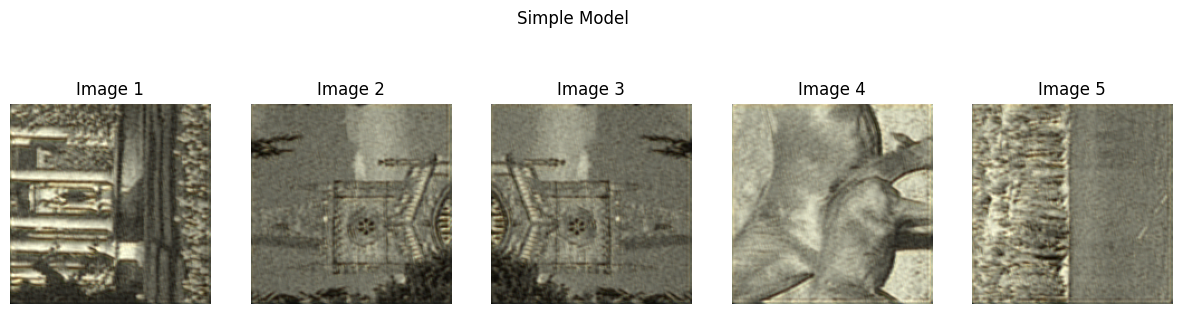

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


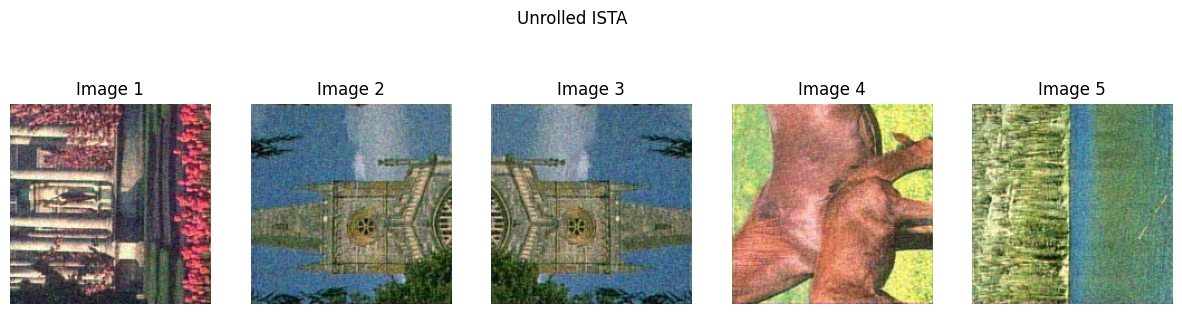

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
for i in range(5):
    axes[i].imshow(np.transpose(test_noisy_images[i,:,:,:].detach().numpy(), (1,2,0)).astype(int), cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.suptitle("Noisy Images")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
for i in range(5):
    axes[i].imshow(np.transpose(test_clean_images[i,:,:,:].detach().numpy(), (1,2,0)).astype(int), cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.suptitle("Original Images")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
for i in range(5):
    axes[i].imshow(np.transpose(simpleNN[i,:,:,:].detach().numpy(), (1,2,0)).astype(int), cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.suptitle("Simple Model")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
for i in range(5):
    axes[i].imshow(np.transpose(unrolledISTAPredictions[i,:,:,:].detach().numpy(), (1,2,0)).astype(int), cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.suptitle("Unrolled ISTA")
plt.show()


My simple model appear to be outputting a greyscale image. I am not sure why this is the case, because I consistently have three channels throughout the model. This makes it harder to compare to the ISTA model. Though, even with the greyscale, it does appear to be a bit fuzzier than the ISTA model. 

Visually, it also seems to me that the unrolled ISTA performs better than the unrolled deep prior model. 

In [33]:
def calcAveragePSNR(ytest, ypred):
    """Calculates the average PSNR over a whole dataset of images, with its noisy or reconstructed counterpart

    Args:
        ytest (_type_): dataset of original images
        ypred (_type_): dataset of reconstructed or noisy images you wish to compare with
    """

    # initialize a list to store the PSNR values
    psnrs = []

    # iterate over the selected indices and compute PSNR for each image
    for ind in range(np.shape(ytest)[0]):
        psnr = peak_signal_noise_ratio(ytest[ind,].numpy(), ypred[ind,].numpy(), data_range=255)
        psnrs.append(psnr)

    # compute the average PSNR
    avg_psnr = np.mean(psnrs)

    return avg_psnr

Average PSNR of noise:

In [36]:
calcAveragePSNR(test_clean_images, test_noisy_images)

20.651767632902658

Average PSNR of unrolled ISTA:

In [34]:
calcAveragePSNR(test_clean_images, unrolledISTAPredictions.squeeze(3).detach())

24.88267779139664

Average PSNR of baseline model: 

In [35]:
calcAveragePSNR(test_clean_images, simpleNN.squeeze(3).detach())

20.75775989299853

First of all, the noise PSNR is the same in the Unrolled Deep Prior notebook, which is a good check that nothing has unexpectedly changed. 

We see that the result from the baseline model is almost the same as noise in this case. I believe this is due to the output of the simple model being in greyscale. 

I do not have an external point of reference for unrolled ISTA's average PSNR. We do know however that it is about the same as that of Unrolled Deep Prior's. These two algorithms are different enough that I cannot compare them to create a theoretically based hypothesis of which should perform better. With more time, one thing we could do to test if their performance was truly the same would be to test on multiple datasets. We could also train both for longer amounts of time, and track their test PSNR on this dataset as a function of training time. 

# Sources

[1] H. T. V. Le, N. Pustelnik, and M. Foare, “The faster proximal algorithm, the better unfolded deep learning architecture ? The study case of image denoising,” in 2022 30th European Signal Processing Conference (EUSIPCO), Belgrade, Serbia: IEEE, Aug. 2022, pp. 947–951. doi: 10.23919/EUSIPCO55093.2022.9909592.

[2] Y. Li, M. Tofighi, V. Monga, and Y. C. Eldar, “An Algorithm Unrolling Approach to Deep Image Deblurring,” in ICASSP 2019 - 2019 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), May 2019, pp. 7675–7679. doi: 10.1109/ICASSP.2019.8682542.

[3] V. Monga, Y. Li, and Y. C. Eldar, “Algorithm Unrolling: Interpretable, Efficient Deep Learning for Signal and Image Processing,” IEEE Signal Processing Magazine, vol. 38, no. 2, pp. 18–44, Mar. 2021, doi: 10.1109/MSP.2020.3016905.
